<a href="https://colab.research.google.com/github/saptarshimazumdar/deep-learning-concepts/blob/a1q1/dataset-trial/spam-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [ ]:
df = pd.read_csv("hf://datasets/bvk/ENRON-spam/Enron_Txt_fn.csv")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = df[['label', 'email']]
df['email'] = df['email'].str.encode('utf-8').str.decode('unicode_escape')
df['email'] = df['email'].str.replace(r'[\n\r\t]', ' ', regex=True)
df['email'] = df['email'].str.replace(r'Subject:\s*', '', regex=True)
df['email'] = df['email'].str.replace(r'Re *:\s*', '', case=False, regex=True).str.replace(r'Fwd *:\s*', '', case=False, regex=True)
df['email'] = df['email'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
df.head()

,label,email
0,0,christmas tree farm pictures
1,0,rankings thank you
2,0,leadership development pilot sally what tim...
3,0,key dates and impact of upcoming sap implement...
4,0,key hr issues going forward a year end revi...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['email'], df['label'], test_size=0.2)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [ ]:
sigmoid = lambda _z: (1 / (1 + np.exp(-_z)))

def binary_cross_entropy(_y, _y_pred, _tolerance=1e-15):
  _y_pred = np.clip(_y_pred, _tolerance, 1 - _tolerance)
  return -np.mean(_y * np.log(_y_pred) + (1 - _y) * np.log(1 - _y_pred))

def mean_squared_error(_y, _y_pred):
  return np.mean((_y_pred-_y) ** 2)

def prediction_probability(_X, _calculated_weights, _calculated_bias):
  return sigmoid(np.dot(_X, _calculated_weights) + _calculated_bias)

def predict(_X, _calculated_weights, _calculated_bias):
  return [1 if label_probability > 0.5 else 0 for label_probability in prediction_probability(_X, _calculated_weights, _calculated_bias)]

def logistic_regression(X, y, _learning_rate, _max_iterations, error_threshold=1e-15):
  n_samples, n_features = X.shape
  weights = np.zeros(n_features)
  bias = [0]
  variances = [0]
  mse = [0]
  bce = [0]

  for i in tqdm(range(_max_iterations)):
    y_pred = prediction_probability(X, weights, bias[-1])
    error= y_pred - y
    # Gradients:

    # Weight ::: dL/dw = 1/m * X^T * (y_pred - y)
    dw = (1 / n_samples) * np.dot(X.T, error)

    # Bias ::: dL/db = 1/m * sum(y_pred - y)
    db = (1 / n_samples) * np.sum(y_pred - y)

    weights -= _learning_rate * dw
    bias.append(_learning_rate * db)
    variances.append(np.var(y_pred))
    mse.append(mean_squared_error(y, y_pred))
    bce.append(binary_cross_entropy(y, y_pred))

    if i > 2 and abs(bce[-2] - bce[-1]) < error_threshold:
      break

  return (weights, bias[-1], {
      "bias": bias[1:],
      "variance": variances[1:],
      "mse": mse[1:],
      "bce": bce[1:]
  })

In [ ]:
learning_rate     = 0.01
iterations        = 1000

(final_weights, final_bias, insights) = logistic_regression(X_train_tfidf, y_train, learning_rate, iterations)
y_test_predicted = predict(X_test_tfidf, final_weights, final_bias)
cm = confusion_matrix(y_test, y_test_predicted)
[[TN, FP], [FN, TP]] = cm
accuracy_df = (y_test == y_test_predicted).value_counts()
accuracy = accuracy_df[True] / (accuracy_df[True] + accuracy_df[False])
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)
specificity = TN/ (TN + FP)

100%|██████████| 1000/1000 [00:23<00:00, 43.15it/s]


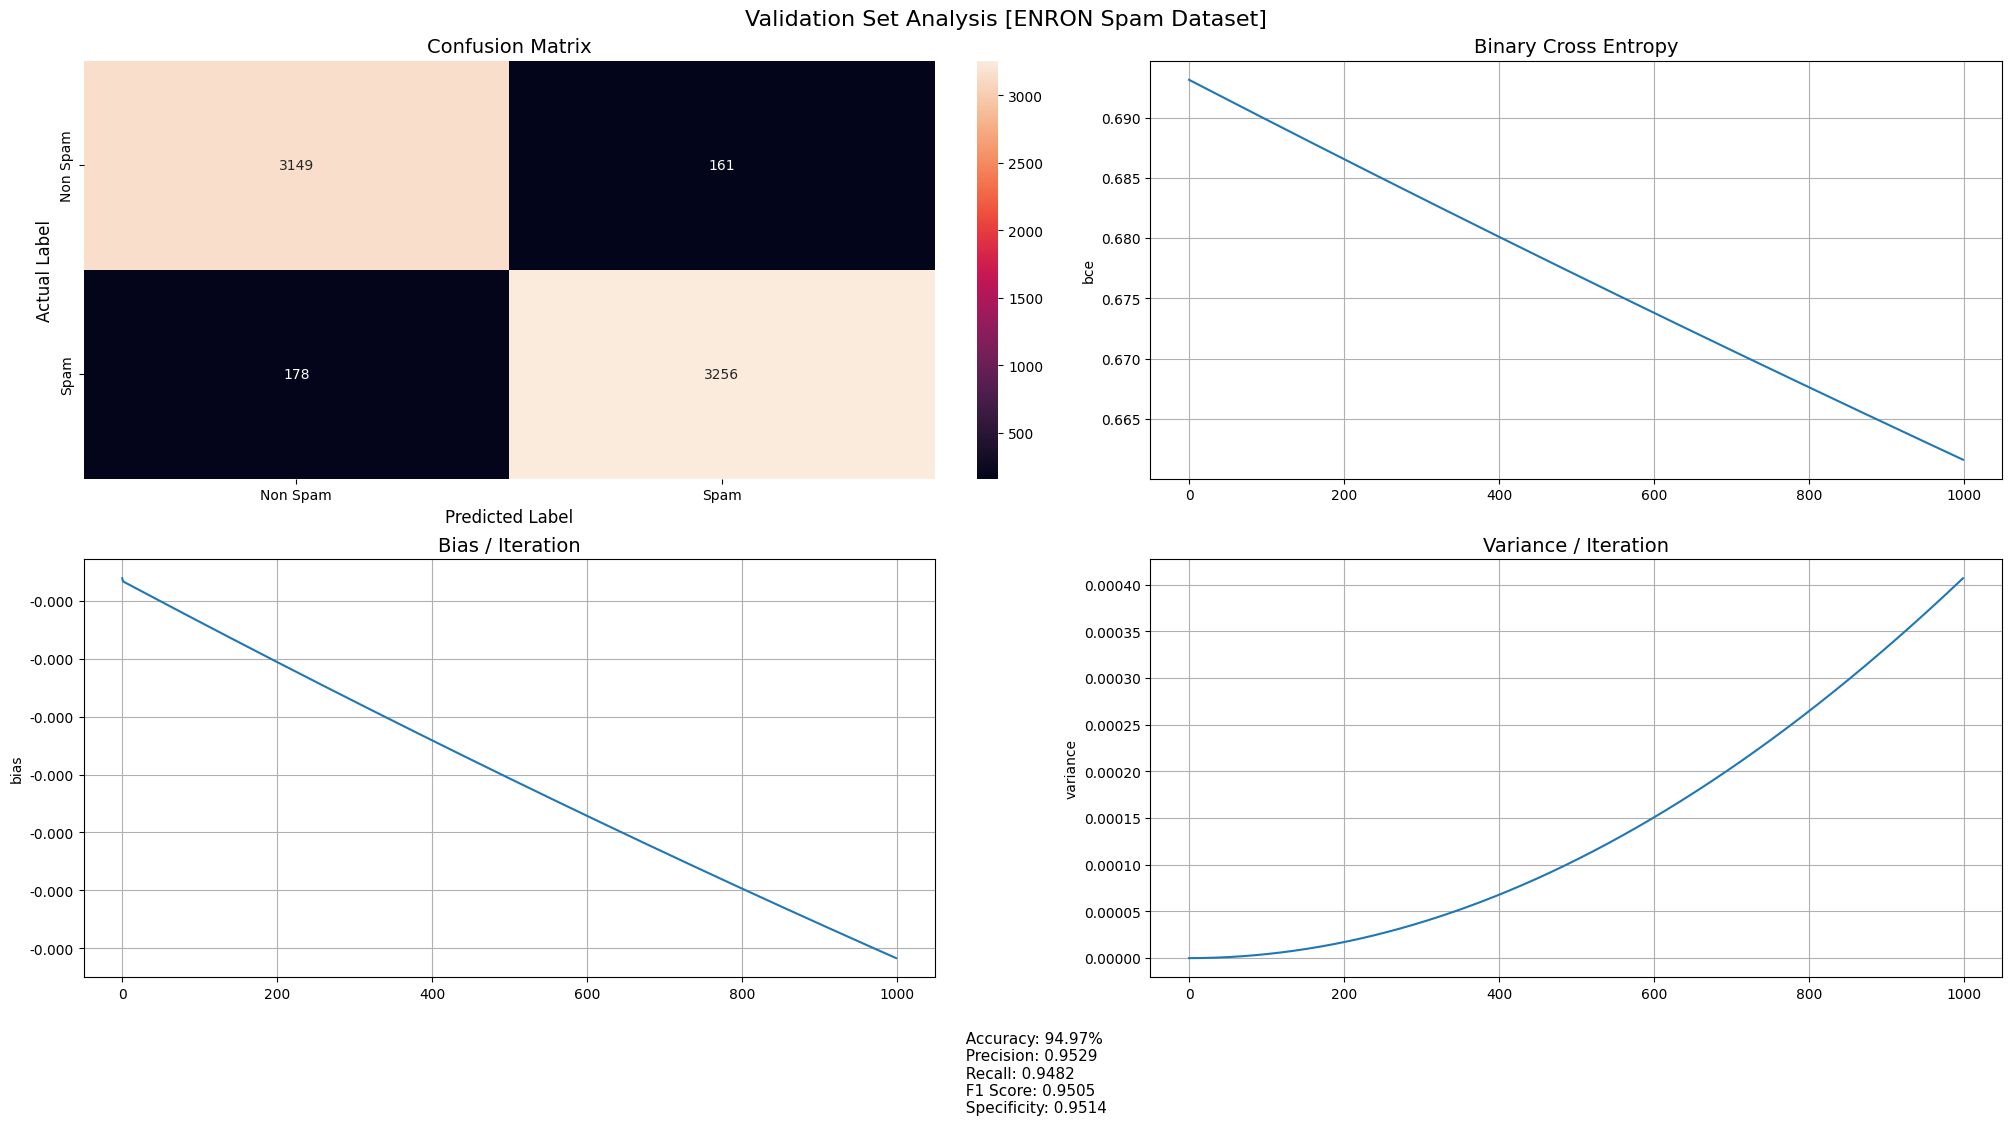

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), layout="constrained")

fig.suptitle('Validation Set Analysis [ENRON Spam Dataset]', fontsize=16)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'], ax=axes[0][0])
axes[0][0].set_title('Confusion Matrix', fontsize=14)
axes[0][0].set_ylabel('Actual Label', fontsize=12)
axes[0][0].set_xlabel('Predicted Label', fontsize=12)

# sns.lineplot(x=range(iterations), y="mse", data = insights, ax=axes[0][1])
sns.lineplot(x=range(iterations), y="bce", data = insights, ax=axes[0][1])
axes[0][1].set_title(f"Binary Cross Entropy", fontsize=14)
axes[0][1].grid()
axes[0][1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

sns.lineplot(x=range(iterations), y="bias", data = insights, ax=axes[1][0])
axes[1][0].set_title(f"Bias / Iteration", fontsize=14)
axes[1][0].grid()
axes[1][0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

sns.lineplot(x=range(iterations), y="variance", data = insights, ax=axes[1][1])
axes[1][1].set_title(f"Variance / Iteration", fontsize=14)
axes[1][1].grid()

fig.text(0.475, -0.125, f"""
  Accuracy: {(accuracy * 100):.2f}%
  Precision: {precision:.4f}
  Recall: {recall:.4f}
  F1 Score: {f1_score:.4f}
  Specificity: {specificity:.4f}
""", fontsize=11)

plt.show()

In [ ]:
df_test = pd.read_csv("hf://datasets/bvk/SMS-spam/SMS_Text.csv")
df_test['data'] = df_test['data'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
df_test.head(2)

,label,data
0,1,Free entry in 2 a wkly comp to win FA Cup fina...
1,1,FreeMsg Hey there darling its been 3 weeks now...


In [ ]:
X_unknown_tfidf = tfidf_vectorizer.transform(df_test['data']).toarray()
y_unknown = df_test['label']
y_unknown_predicted = predict(X_unknown_tfidf, final_weights, final_bias)

cm_unknown = confusion_matrix(y_unknown, y_unknown_predicted)
[[TN_unknown, FP_unknown], [FN_unknown, TP_unknown]] = cm_unknown
accuracy_unknown = (TP_unknown + TN_unknown) / y_unknown.shape[0]
precision_unknown = TP_unknown / (TP_unknown + FP_unknown)
recall_unknown = TP_unknown / (TP_unknown + FN_unknown)
f1_score_unknown = 2 * precision_unknown * recall_unknown / (precision_unknown + recall_unknown)
specificity_unknown = TN_unknown / (TN_unknown + FP_unknown)

fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted)
roc_auc = roc_auc_score(y_test, y_test_predicted)

fpr_unk, tpr_unk, thresholds_unk = roc_curve(y_unknown, y_unknown_predicted)
roc_auc_unk = roc_auc_score(y_unknown, y_unknown_predicted)

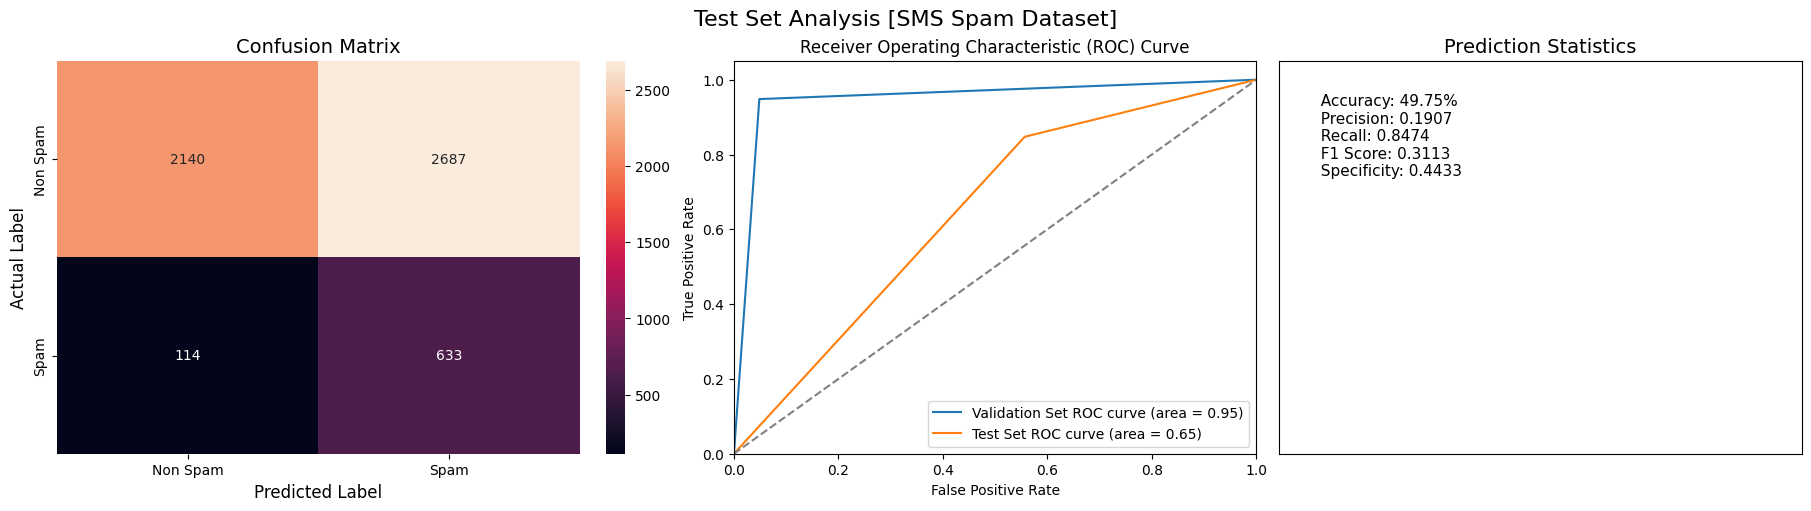

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), layout="constrained")

fig.suptitle('Test Set Analysis [SMS Spam Dataset]', fontsize=16)

sns.heatmap(cm_unknown, annot=True, fmt='d', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'], ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Actual Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

axes[1].plot(fpr, tpr, label=f'Validation Set ROC curve (area = {roc_auc:0.2f})')
axes[1].plot(fpr_unk, tpr_unk, label=f'Test Set ROC curve (area = {roc_auc_unk:0.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

axes[2].set_title(f"Prediction Statistics", fontsize=14)
axes[2].set_xticks([])
axes[2].set_yticks([])

fig.text(0.725, 0.625, f"""
  Accuracy: {(accuracy_unknown * 100):.2f}%
  Precision: {precision_unknown:.4f}
  Recall: {recall_unknown:.4f}
  F1 Score: {f1_score_unknown:.4f}
  Specificity: {specificity_unknown:.4f}
""", fontsize=11)

plt.show()

## **5 Fold Cross Validation Experiment**

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_iteration_response_weights = []
for fold, (train_index, test_index) in enumerate(kf.split(df)):
  train_set = df.iloc[train_index]
  test_set = df.iloc[test_index]
  temporary_tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
  temporary_X_train_tfidf = tfidf_vectorizer.fit_transform(train_set['email']).toarray()
  temporary_X_test_tfidf = tfidf_vectorizer.transform(test_set['email']).toarray()
  (temporary_final_weights, temporary_final_bias, temporary_insights) = logistic_regression(temporary_X_train_tfidf, train_set['label'], learning_rate, iterations)
  temporary_y_test_predicted = predict(temporary_X_test_tfidf, temporary_final_weights, temporary_final_bias)
  temporary_cm = confusion_matrix(test_set['label'], temporary_y_test_predicted)
  kf_iteration_response_weights.append({
      "weights": temporary_final_weights,
      "cm": temporary_cm,
      "bias": temporary_final_bias
  })

100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


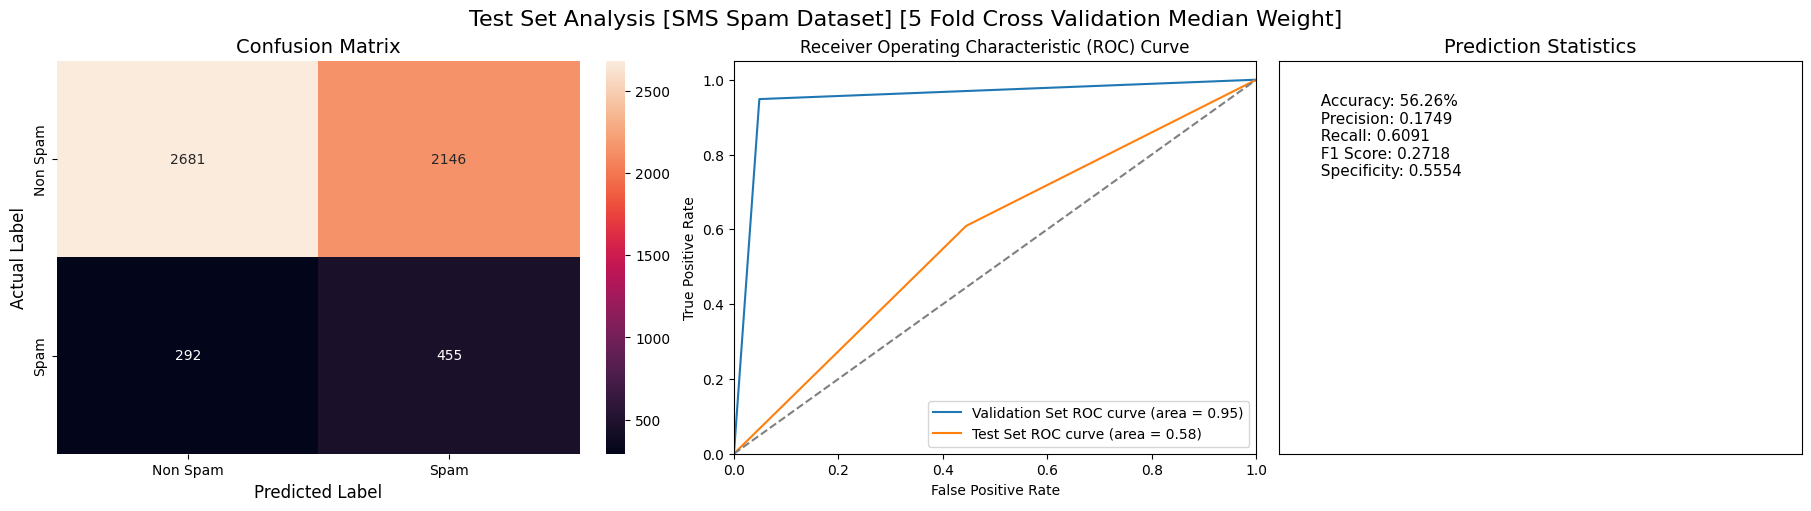

In [ ]:
kfcv_weights = np.median([iteration['weights'] for iteration in kf_iteration_response_weights], axis=0)
kfcv_bias = np.median([iteration['bias'] for iteration in kf_iteration_response_weights])
y_unknown_predicted_kfcv = predict(X_unknown_tfidf, kfcv_weights, kfcv_bias)

cm_unknown = confusion_matrix(y_unknown, y_unknown_predicted_kfcv)
[[TN_unknown, FP_unknown], [FN_unknown, TP_unknown]] = cm_unknown
accuracy_unknown = (TP_unknown + TN_unknown) / y_unknown.shape[0]
precision_unknown = TP_unknown / (TP_unknown + FP_unknown)
recall_unknown = TP_unknown / (TP_unknown + FN_unknown)
f1_score_unknown = 2 * precision_unknown * recall_unknown / (precision_unknown + recall_unknown)
specificity_unknown = TN_unknown / (TN_unknown + FP_unknown)

fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted)
roc_auc = roc_auc_score(y_test, y_test_predicted)

fpr_unk, tpr_unk, thresholds_unk = roc_curve(y_unknown, y_unknown_predicted_kfcv)
roc_auc_unk = roc_auc_score(y_unknown, y_unknown_predicted_kfcv)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), layout="constrained")
fig.suptitle('Test Set Analysis [SMS Spam Dataset] [5 Fold Cross Validation Median Weight]', fontsize=16)

sns.heatmap(cm_unknown, annot=True, fmt='d', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'], ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Actual Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

axes[1].plot(fpr, tpr, label=f'Validation Set ROC curve (area = {roc_auc:0.2f})')
axes[1].plot(fpr_unk, tpr_unk, label=f'Test Set ROC curve (area = {roc_auc_unk:0.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

axes[2].set_title(f"Prediction Statistics", fontsize=14)
axes[2].set_xticks([])
axes[2].set_yticks([])

fig.text(0.725, 0.625, f"""
  Accuracy: {(accuracy_unknown * 100):.2f}%
  Precision: {precision_unknown:.4f}
  Recall: {recall_unknown:.4f}
  F1 Score: {f1_score_unknown:.4f}
  Specificity: {specificity_unknown:.4f}
""", fontsize=11)

plt.show()

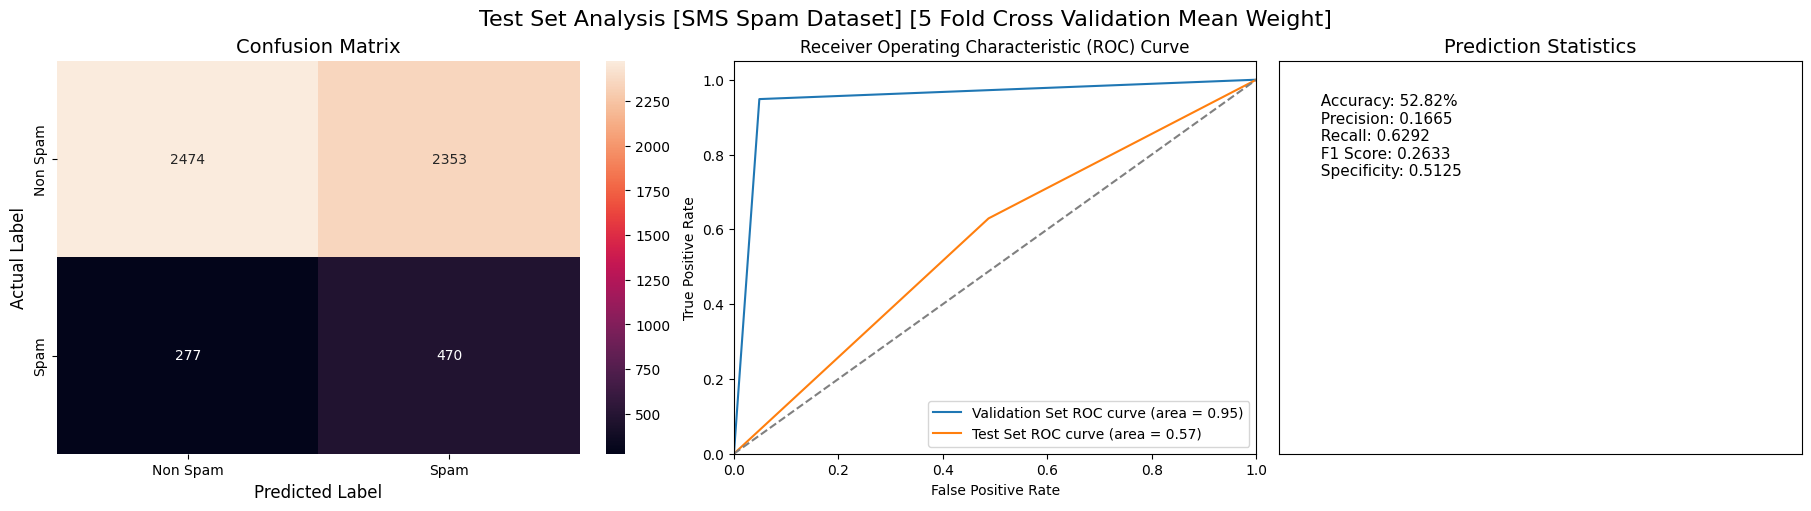

In [ ]:
kfcv_weights = np.mean([iteration['weights'] for iteration in kf_iteration_response_weights], axis=0)
kfcv_bias = np.mean([iteration['bias'] for iteration in kf_iteration_response_weights])
y_unknown_predicted_kfcv = predict(X_unknown_tfidf, kfcv_weights, kfcv_bias)

cm_unknown = confusion_matrix(y_unknown, y_unknown_predicted_kfcv)
[[TN_unknown, FP_unknown], [FN_unknown, TP_unknown]] = cm_unknown
accuracy_unknown = (TP_unknown + TN_unknown) / y_unknown.shape[0]
precision_unknown = TP_unknown / (TP_unknown + FP_unknown)
recall_unknown = TP_unknown / (TP_unknown + FN_unknown)
f1_score_unknown = 2 * precision_unknown * recall_unknown / (precision_unknown + recall_unknown)
specificity_unknown = TN_unknown / (TN_unknown + FP_unknown)

fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted)
roc_auc = roc_auc_score(y_test, y_test_predicted)

fpr_unk, tpr_unk, thresholds_unk = roc_curve(y_unknown, y_unknown_predicted_kfcv)
roc_auc_unk = roc_auc_score(y_unknown, y_unknown_predicted_kfcv)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), layout="constrained")
fig.suptitle('Test Set Analysis [SMS Spam Dataset] [5 Fold Cross Validation Mean Weight]', fontsize=16)

sns.heatmap(cm_unknown, annot=True, fmt='d', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'], ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Actual Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

axes[1].plot(fpr, tpr, label=f'Validation Set ROC curve (area = {roc_auc:0.2f})')
axes[1].plot(fpr_unk, tpr_unk, label=f'Test Set ROC curve (area = {roc_auc_unk:0.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

axes[2].set_title(f"Prediction Statistics", fontsize=14)
axes[2].set_xticks([])
axes[2].set_yticks([])

fig.text(0.725, 0.625, f"""
  Accuracy: {(accuracy_unknown * 100):.2f}%
  Precision: {precision_unknown:.4f}
  Recall: {recall_unknown:.4f}
  F1 Score: {f1_score_unknown:.4f}
  Specificity: {specificity_unknown:.4f}
""", fontsize=11)

plt.show()